In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
# from langchain_astradb import AstraDBVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
# from langchain import hub
from langchain.schema import Document
from langgraph.graph import START, StateGraph, END
from typing import Literal, List
from typing_extensions import TypedDict
from dotenv import load_dotenv
from PIL import Image
import json
# from IPython.display import Image
import easyocr
import os

In [17]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(api_key = GOOGLE_API_KEY, model = "gemini-1.5-pro",temperature = 0.1)

In [12]:
R = llm.invoke(f"Can you summarize medical reports?").content
print(R)

Yes, I can summarize medical reports.  However, I am an AI and **cannot provide medical advice**.  My summaries are for informational purposes only and should not be used to make decisions about your health.  Always consult with a qualified medical professional for diagnosis and treatment.

I can help by:

* **Extracting key findings:**  I can identify and present the most important results from lab tests, imaging studies, and other diagnostic procedures.
* **Summarizing diagnoses and treatment plans:** I can condense the information about the diagnosed conditions and the recommended course of action.
* **Simplifying complex medical jargon:** I can explain technical terms in more accessible language.
* **Identifying medications and dosages:** I can list the prescribed medications, their dosages, and frequency of administration.
* **Highlighting follow-up recommendations:** I can point out scheduled appointments and recommended next steps.

To help me provide the best summary, please pr

In [73]:
class GraphState(TypedDict):
    report : str
    generation : str    
    summary : str
    translation: str
    Anamoly : str
    root_cause : str
    path : str

In [74]:
def ocr(state):
    path = state["path"]
    reader = easyocr.Reader(['en'])
    result = reader.readtext(path)
    response = [detection[1] for detection in result]
    response_text = '\n'.join(response)
    print("HI")
    return {"report" : response_text}

In [75]:
def report(state):
    report = state["report"]
    response = llm.invoke(f"You are being provided a medical report correct this grammatically{report} Note: Do not add anything extra. Just return the report as it is.").content
    print("INSIDE REPORT")
    return {"generation" : response}

In [76]:
def generate_summary(state):
    generation = state["generation"]

    response = llm.invoke(f"""You are an Expert in Evaluating medical Reports.You are given the report, 
                          Based on the report Devise a comprehensive of the report in not more than 150 words.
                          Note: The summary you generate should be generated in layman terms. Keep the summary as 
                          simple as possible. report {generation}""").content
    print("INSIDE SUMMARY")
    print(response)
    
    return {"summary" : response}

In [77]:
def anamoly_detection(state):#this is an edge
    summary = state["summary"]

    class Route_Anamoly(BaseModel):
        Binary_Score: str = Field(..., description="Does this report contain abnormal values? Yes or No")

    structured_llm = llm.with_structured_output(Route_Anamoly)

    system = """
    You are provided with a summary of a medical report containing various measurements and observations. 
    Your task is to identify any abnormal values or measurements. A value is considered abnormal if it is described as "elevated," "low," "absent," or if it falls outside the reference range.
    If any abnormal values are found, respond with 'Yes'. If no abnormal values are found, or if the summary lacks numerical data, respond with 'No'.
    """

    binary_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "report:{report}")
        ]
    )

    grader_chain = binary_prompt | structured_llm

    llm_response = grader_chain.invoke({"report": summary})
    print("Detecting anamoly")
    if llm_response.Binary_Score == "Yes":
        return "Anamoly"
    else:
        return "Normal"


In [78]:
def value_extractor(state):
    summary = state["summary"]

    system = """
    You are given a medical report summary that includes various measurements and observations. 
    Your task is to identify and extract all values or measurements that are described as abnormal. 
    A value is considered abnormal if it is described as "elevated," "low," "absent," or if it is outside the reference range.
    Return the abnormal values along with the associated measurement.
    If no abnormal values are found, respond with 'None'.
    """
    print("hey")
    extraction_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", f"summary: {summary}")
        ]
    )

    chain = extraction_prompt | llm
    extracted_values = chain.invoke({summary : summary})
    extracted_values = extracted_values.content
    print("Exiting the extacted values node")
    print(extracted_values)
    return {"Anamoly": extracted_values}


In [79]:
# def root_cause(state):
#     summary = state["summary"]

#     system = """
#             Hey, You are given a summary of the report. Based on the summary you have to generate
#             The possible Root causes of the summary and provide it in a concise manner"""
    
#     extraction_prompt = ChatPromptTemplate.from_messages(
#         [
#             ("system", system),
#             "human", f"summary : {summary}"
#         ]
#     )

#     chain = extraction_prompt | llm
#     root_causes = chain.invoke({summary : summary})
#     root_causes = root_causes.content
#     print(root_causes)
    

In [80]:
def root_cause(state):#THIS IS A NODE
    anamoly = state["Anamoly"]
    response = llm.invoke(f"""From the given extracted values find out the root causes.
                          NOTE: Only find out root cause and nothing else. Values{anamoly}""")
    response = response.content

    print(response)
    return {"root_cause" : response}

In [81]:
def root_cause_1(state):
    anamoly = state["Anamoly"]

    response_1 = llm.invoke(f"""From the given extracted values find out the root causes.
                            NOTE: Only find out root cause and nothing else. Values{anamoly}""")
    response_1 = response_1.content

    print(response_1)
    return {"root_cause" : response_1}

In [82]:
workflow = StateGraph(GraphState)

workflow.add_node("ocr_node", ocr)
workflow.add_node("report_node", report)
workflow.add_node("generate_summary_node", generate_summary)
# workflow.add_node("Translation_node",Translate_Summary)
workflow.add_node("value_extractor_node", value_extractor)
workflow.add_node("root_cause_node", root_cause)
workflow.add_node("root_cause_1_node", root_cause_1)

workflow.add_edge(START, "ocr_node")
workflow.add_edge("ocr_node", "report_node")
workflow.add_edge("report_node", "generate_summary_node")
# workflow.add_edge("generate_summary_node","Translation_node")
workflow.add_edge("generate_summary_node", END)
# workflow.add_edge("Translation_node",END)

workflow.add_conditional_edges("generate_summary_node", anamoly_detection,{
    "Anamoly" : "value_extractor_node",
    "Normal": "root_cause_1_node"
})

workflow.add_edge("root_cause_1_node", END)

workflow.add_edge("value_extractor_node", "root_cause_node")
workflow.add_edge("root_cause_node", END)

app = workflow.compile()

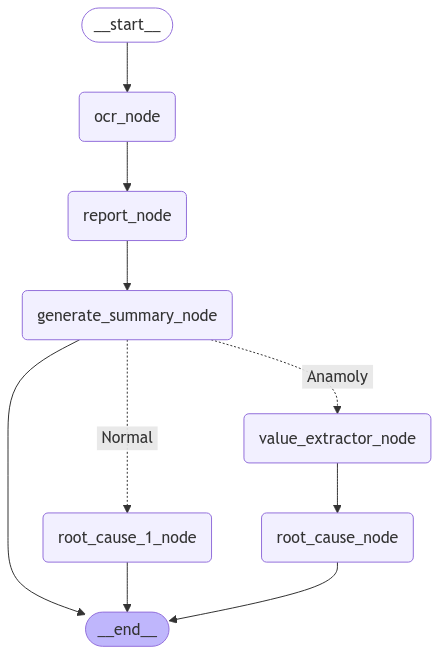

In [83]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [84]:
from pprint import pprint
inputs = {
    "path": r"C:\Users\aashutosh kumar\OneDrive\Pictures\WhatsApp Image 2024-08-29 at 18.24.59_e668341d.jpg"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
# pprint(value["generation"])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


HI
"Node 'ocr_node':"
'\n---\n'
INSIDE REPORT
"Node 'report_node':"
'\n---\n'
INSIDE SUMMARY
A skin biopsy from the chest of a 57-year-old male patient, Davidi Test, confirmed a diagnosis of Grover's disease.  Microscopic examination revealed characteristic features of this condition, including small splits within the skin layers, detached skin cells, and specific cell formations (corps ronds and grains). The sample, measuring 0.4 cm wide and 0.6 cm deep, was processed and examined at Regional Medical Laboratory. The report was issued on February 29, 2008, and printed on July 18, 2008.

Detecting anamoly
"Node 'generate_summary_node':"
'\n---\n'


KeyError: 'Anamoly'